### 这是一个火力发电厂的真实脱敏数据集，现在我们要用机器学习来预测产生的蒸汽量。

#### 导入相关库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams["axes.unicode_minus"] = False  # 正确显示负号

#### 定义可视化函数

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_regression_results(y_true, y_pred, title="回归模型拟合效果"):
    """
    可视化回归模型拟合效果
    参数:
        y_true: array-like, 真实值
        y_pred: array-like, 预测值
        title: str, 图表标题
    """
    plt.figure(figsize=(12, 5))

    # 子图1：预测值 vs 真实值
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 
             'r--', lw=2, label="理想拟合线")
    plt.xlabel("真实值")
    plt.ylabel("预测值")
    plt.title(f"{title} - 预测 vs 真实")
    plt.legend()

    # 子图2：残差分布
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel("预测值")
    plt.ylabel("残差")
    plt.title(f"{title} - 残差图")

    plt.tight_layout()
    plt.show()


#### 可视化模型系数

In [3]:
def plot_coefficients(models, feature_names):
    """
    对比不同回归模型的系数
    models: dict, {'模型名': fitted_model}
    feature_names: list, 特征名称
    """
    plt.figure(figsize=(10, 6))
    for name, model in models.items():
        coefs = model.named_steps[list(model.named_steps.keys())[-1]].coef_
        plt.plot(coefs, marker='o', label=name)
    
    plt.xticks(range(len(feature_names)), feature_names, rotation=45)
    plt.xlabel("特征")
    plt.ylabel("系数值")
    plt.title("Ridge vs Lasso 系数对比")
    plt.legend()
    plt.tight_layout()
    plt.show()

#### 读取并查看数据

In [4]:
df_train = pd.read_csv('data/测试项目要求/zhengqi_train.txt',sep='\t')
df_test = pd.read_csv('data/测试项目要求/zhengqi_test.txt',sep='\t')
# df_train = pd.read_table('data/测试项目要求/zhengqi_train.txt')
# df_test = pd.read_table('data/测试项目要求/zhengqi_test.txt')


In [5]:
df_train.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,-0.009,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.015,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.206
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,0.183,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.384


In [6]:
df_test.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,0.368,0.380,-0.225,-0.049,0.379,0.092,0.550,0.551,0.244,0.904,...,-0.449,0.047,0.057,-0.042,0.847,0.534,-0.009,-0.190,-0.567,0.388
1,0.148,0.489,-0.247,-0.049,0.122,-0.201,0.487,0.493,-0.127,0.904,...,-0.443,0.047,0.560,0.176,0.551,0.046,-0.220,0.008,-0.294,0.104
2,-0.166,-0.062,-0.311,0.046,-0.055,0.063,0.485,0.493,-0.227,0.904,...,-0.458,-0.398,0.101,0.199,0.634,0.017,-0.234,0.008,0.373,0.569
3,0.102,0.294,-0.259,0.051,-0.183,0.148,0.474,0.504,0.010,0.904,...,-0.456,-0.398,1.007,0.137,1.042,-0.040,-0.290,0.008,-0.666,0.391
4,0.300,0.428,0.208,0.051,-0.033,0.116,0.408,0.497,0.155,0.904,...,-0.458,-0.776,0.291,0.370,0.181,-0.040,-0.290,0.008,-0.140,-0.497


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V0      2888 non-null   float64
 1   V1      2888 non-null   float64
 2   V2      2888 non-null   float64
 3   V3      2888 non-null   float64
 4   V4      2888 non-null   float64
 5   V5      2888 non-null   float64
 6   V6      2888 non-null   float64
 7   V7      2888 non-null   float64
 8   V8      2888 non-null   float64
 9   V9      2888 non-null   float64
 10  V10     2888 non-null   float64
 11  V11     2888 non-null   float64
 12  V12     2888 non-null   float64
 13  V13     2888 non-null   float64
 14  V14     2888 non-null   float64
 15  V15     2888 non-null   float64
 16  V16     2888 non-null   float64
 17  V17     2888 non-null   float64
 18  V18     2888 non-null   float64
 19  V19     2888 non-null   float64
 20  V20     2888 non-null   float64
 21  V21     2888 non-null   float64
 22  

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V0      1925 non-null   float64
 1   V1      1925 non-null   float64
 2   V2      1925 non-null   float64
 3   V3      1925 non-null   float64
 4   V4      1925 non-null   float64
 5   V5      1925 non-null   float64
 6   V6      1925 non-null   float64
 7   V7      1925 non-null   float64
 8   V8      1925 non-null   float64
 9   V9      1925 non-null   float64
 10  V10     1925 non-null   float64
 11  V11     1925 non-null   float64
 12  V12     1925 non-null   float64
 13  V13     1925 non-null   float64
 14  V14     1925 non-null   float64
 15  V15     1925 non-null   float64
 16  V16     1925 non-null   float64
 17  V17     1925 non-null   float64
 18  V18     1925 non-null   float64
 19  V19     1925 non-null   float64
 20  V20     1925 non-null   float64
 21  V21     1925 non-null   float64
 22  

#### 划分数据集

In [9]:
X = df_train.drop('target', axis=1)
y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 训练模型

##### LinearRegression

==========直接模型评估==========
R-squared: 0.8993939788094978
MSE: 0.09626468391443843
MAE: 0.23304319004653423
==========网格搜索模型评估==========
最佳参数： {'line_reg__fit_intercept': True, 'line_reg__positive': False}
最佳模型得分： 0.8993939788094978
R-squared: 0.8774812332855543
MSE: 0.09626468391443843
MAE: 0.23304319004653423


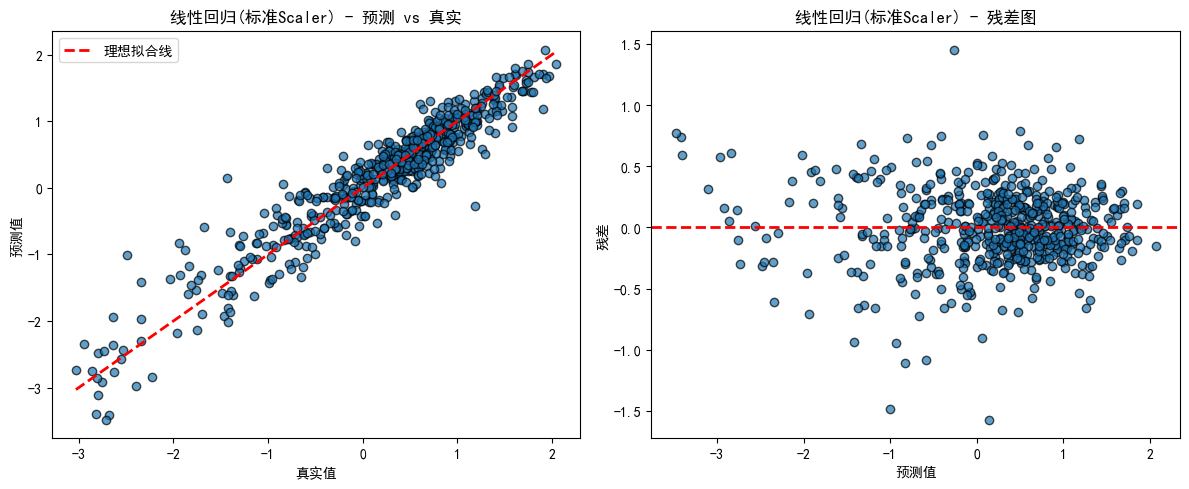

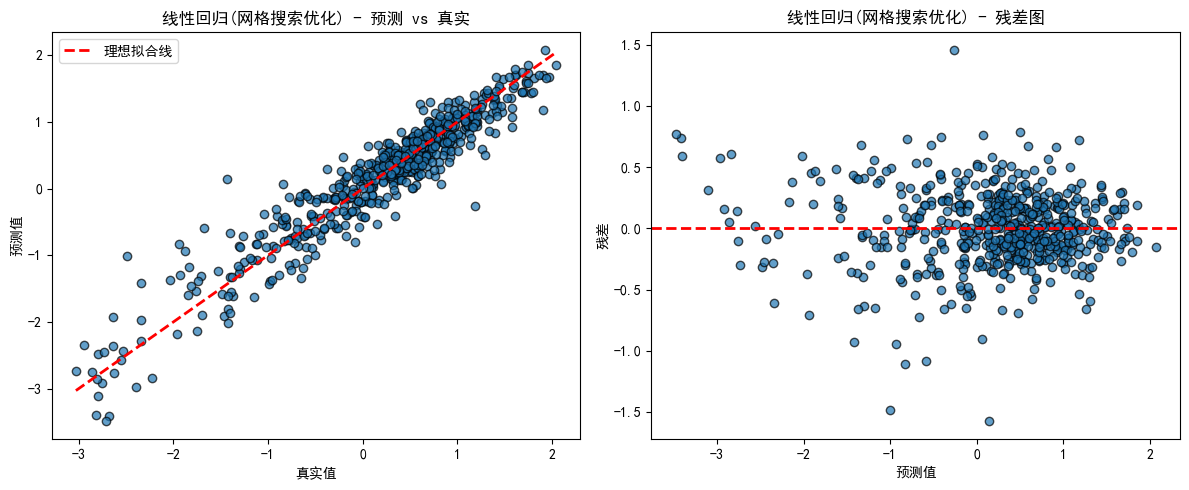

In [10]:
pipe = Pipeline(
    [
        ('std', StandardScaler()),
        ('line_reg', LinearRegression())
    ]
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print('='*10+'直接模型评估'+'='*10)
print('R-squared:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

# 交叉验证&网格搜索
# 定义参数搜索空间
param_grid = {
    'line_reg__fit_intercept': [True, False],
    'line_reg__positive': [True, False]  # 是否强制系数为正
}

# 创建网格搜索对象
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)

# 训练模型
grid_search.fit(X_train, y_train)

# 模型评估
print('='*10+'网格搜索模型评估'+'='*10)
print('最佳参数：', grid_search.best_params_)
print('最佳模型得分：', grid_search.best_estimator_.score(X_test, y_test))
print('R-squared:', grid_search.best_score_)
print('MSE:', mean_squared_error(y_test, grid_search.predict(X_test)))
print('MAE:', mean_absolute_error(y_test, grid_search.predict(X_test)))


# 直接模型可视化
plot_regression_results(y_test, y_pred, title="线性回归(标准Scaler)")

# 网格搜索后的模型可视化
y_pred_gs = grid_search.predict(X_test)
plot_regression_results(y_test, y_pred_gs, title="线性回归(网格搜索优化)")


##### Ridge

==========网格搜索模型评估==========
最佳参数： {'ridge_reg__alpha': 1.0, 'ridge_reg__solver': 'auto'}
最佳模型得分： 0.8993421547999774
R-squared: 0.8775031944301347
MSE: 0.0963142716213831
MAE: 0.23303557672520742


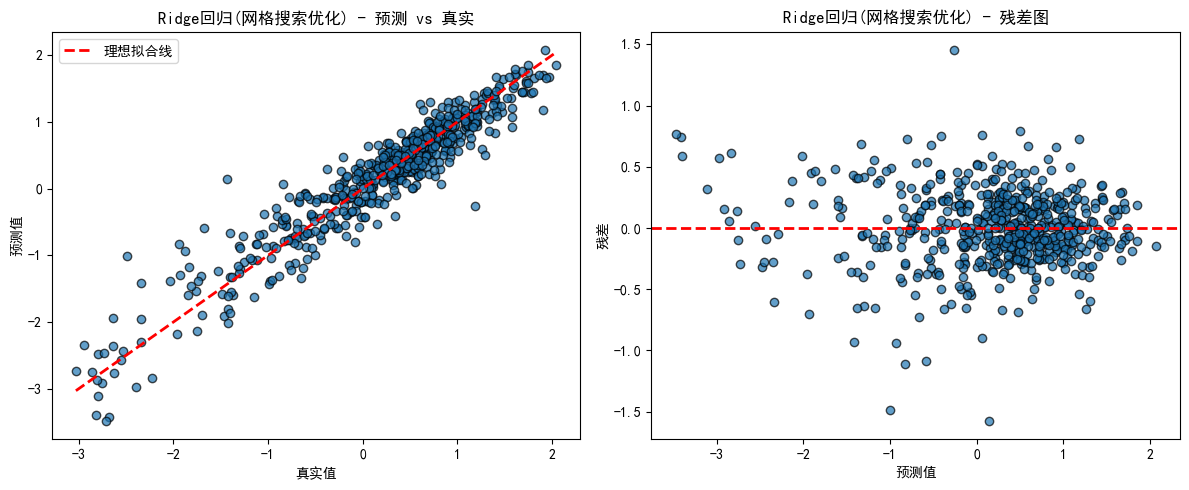

In [11]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('ridge_reg', Ridge())
    ]
)

# 网格搜索参数
param_grid = {
    'ridge_reg__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # 正则化强度
    'ridge_reg__solver': ['auto', 'svd', 'cholesky']  # 求解器
}

# 创建网格搜索
grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid, 
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# 训练模型
grid_search.fit(X_train, y_train)

# 模型评估
print('='*10+'网格搜索模型评估'+'='*10)
print('最佳参数：', grid_search.best_params_)
print('最佳模型得分：', grid_search.best_estimator_.score(X_test, y_test))
print('R-squared:', grid_search.best_score_)
print('MSE:', mean_squared_error(y_test, grid_search.predict(X_test)))
print('MAE:', mean_absolute_error(y_test, grid_search.predict(X_test)))

# 保存模型
grid_search_ridge = grid_search

# 网格搜索后的模型可视化
y_pred_gs = grid_search.predict(X_test)
plot_regression_results(y_test, y_pred_gs, title="Ridge回归(网格搜索优化)")

##### Lasso


==========网格搜索模型评估==========
最佳参数： {'la_reg__alpha': 0.0002592943797404667, 'la_reg__fit_intercept': True, 'la_reg__selection': 'cyclic'}
最佳模型得分： 0.8992880045079876
R-squared: 0.8775441073646295
MSE: 0.09636608522737397
MAE: 0.23299823090693422


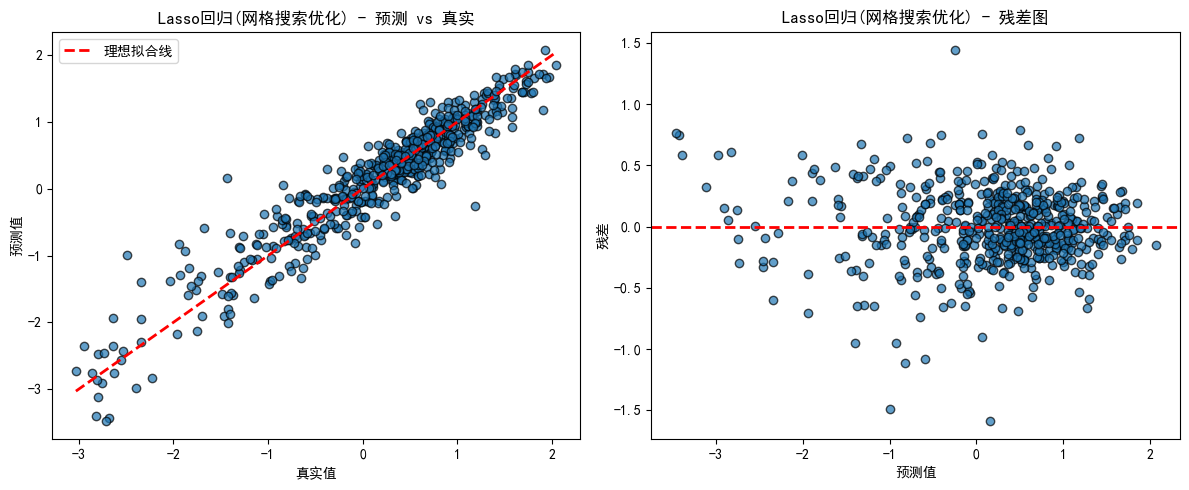

In [12]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('la_reg', Lasso())
    ]
)

# 定义参数空间
param_grid = {
    'la_reg__alpha': np.logspace(-4, 0, 30),  # 正则化强度
    'la_reg__fit_intercept': [True, False],
    'la_reg__selection': ['cyclic', 'random']  # 坐标下降方法
}

# 创建网格搜索对象
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)

# 训练模型
grid_search.fit(X_train, y_train)

# 模型评估
print('='*10+'网格搜索模型评估'+'='*10)
print('最佳参数：', grid_search.best_params_)
print('最佳模型得分：', grid_search.best_estimator_.score(X_test, y_test))
print('R-squared:', grid_search.best_score_)
print('MSE:', mean_squared_error(y_test, grid_search.predict(X_test)))
print('MAE:', mean_absolute_error(y_test, grid_search.predict(X_test)))

# 保存模型
grid_search_lasso = grid_search

# 网格搜索后的模型可视化
y_pred_gs = grid_search.predict(X_test)
plot_regression_results(y_test, y_pred_gs, title="Lasso回归(网格搜索优化)")

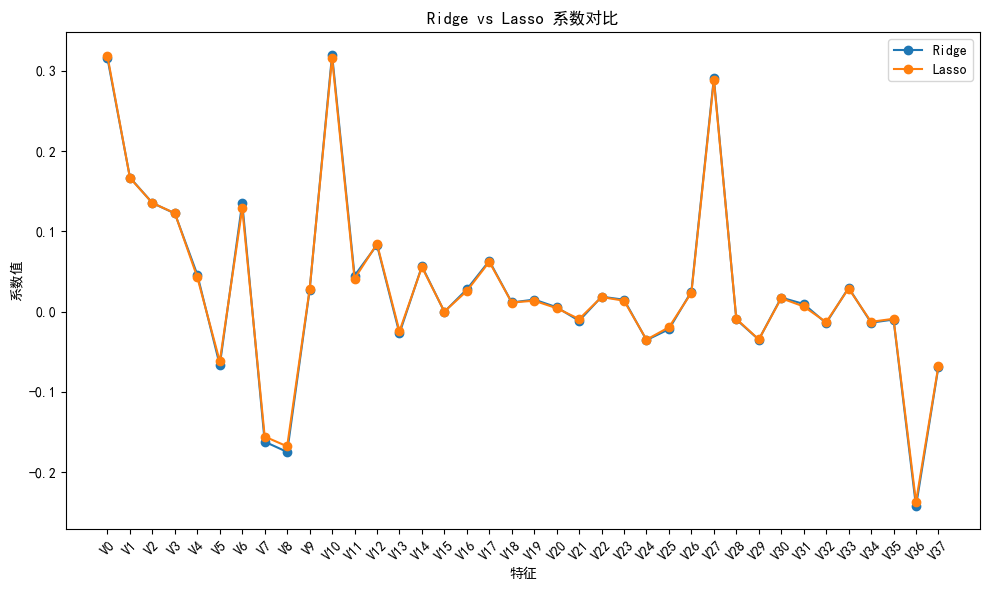

In [13]:
plot_coefficients(
    {
        "Ridge": grid_search_ridge.best_estimator_,
        "Lasso": grid_search_lasso.best_estimator_
    },
    feature_names=X_train.columns  # 如果是DataFrame
)

##### 决策树回归

==========网格搜索模型评估==========
最佳参数： {'tree__max_depth': 5, 'tree__min_samples_split': 8}
最佳模型得分： 0.8147363102391376
R-squared: 0.7915400788050745
MSE: 0.1772692163412548
MAE: 0.3076313497620934


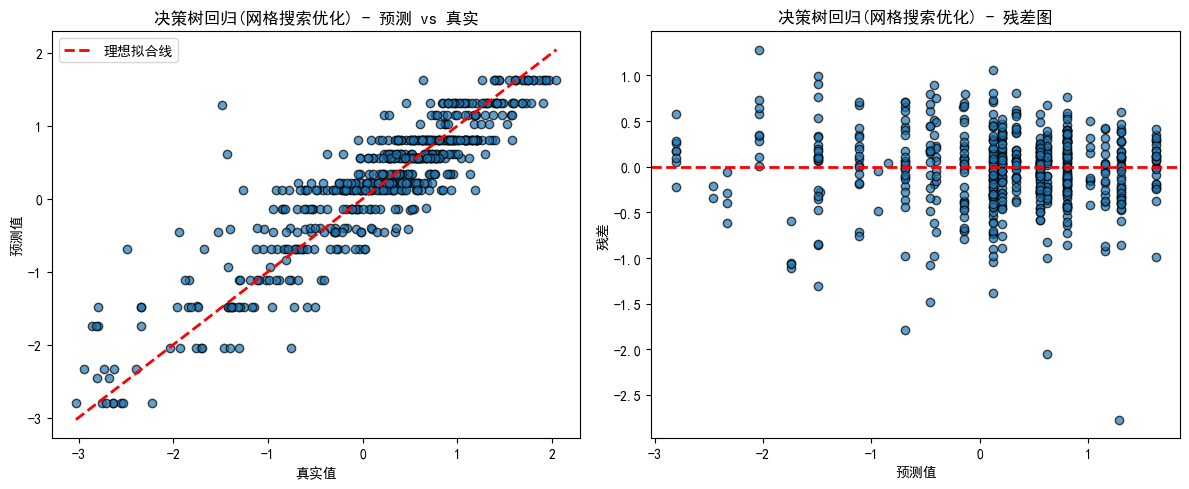

In [14]:
pipe = Pipeline(
    [
        ('scaler',StandardScaler()),
        ('tree',DecisionTreeRegressor())
    ]
)

# 定义网格搜索参数
param_grid = {
    'tree__max_depth':[3,5,7,9],
    'tree__min_samples_split':[2,4,6,8]
}

# 定义交叉验证对象
grid_search = GridSearchCV(pipe,param_grid=param_grid,cv=5)

# 训练模型
grid_search.fit(X_train,y_train)

# 模型评估
print('='*10+'网格搜索模型评估'+'='*10)
print('最佳参数：', grid_search.best_params_)
print('最佳模型得分：', grid_search.best_estimator_.score(X_test, y_test))
print('R-squared:', grid_search.best_score_)
print('MSE:', mean_squared_error(y_test, grid_search.predict(X_test)))
print('MAE:', mean_absolute_error(y_test, grid_search.predict(X_test)))

# 网格搜索后的模型可视化
y_pred_gs = grid_search.predict(X_test)
plot_regression_results(y_test, y_pred_gs, title="决策树回归(网格搜索优化)")

##### KNN回归

==========网格搜索模型评估==========
最佳参数： {'knn_reg__algorithm': 'auto', 'knn_reg__n_neighbors': 10, 'knn_reg__weights': 'distance'}
最佳模型得分： 0.8181690532192016
R-squared: 0.7825391402272196
MSE: 0.1739846026170957
MAE: 0.3043708950750204


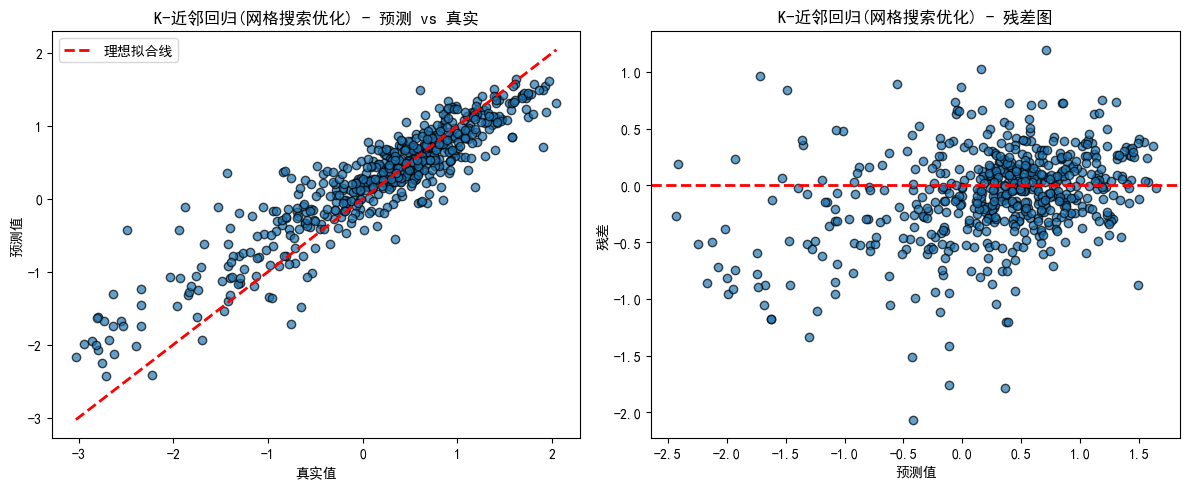

In [15]:
pipe = Pipeline(
    [
        ('scaler',StandardScaler()),
        ('knn_reg',KNeighborsRegressor())
    ]
)

# 网格搜索空间
param_grid = {
    'knn_reg__n_neighbors':[2,3,4,5,6,7,8,9,10],
    'knn_reg__weights':['uniform','distance'],
    'knn_reg__algorithm':['auto','ball_tree','kd_tree','brute']
    }

# 定义网格搜索对象
grid_search = GridSearchCV(pipe,param_grid,cv=5)

# 训练模型
grid_search.fit(X_train,y_train)

# 模型评估
print('='*10+'网格搜索模型评估'+'='*10)
print('最佳参数：', grid_search.best_params_)
print('最佳模型得分：', grid_search.best_estimator_.score(X_test, y_test))
print('R-squared:', grid_search.best_score_)
print('MSE:', mean_squared_error(y_test, grid_search.predict(X_test)))
print('MAE:', mean_absolute_error(y_test, grid_search.predict(X_test)))

# 网格搜索后的模型可视化
y_pred_gs = grid_search.predict(X_test)
plot_regression_results(y_test, y_pred_gs, title="K-近邻回归(网格搜索优化)")

##### 集成学习

In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    StackingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# 定义评估函数
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} 评估结果:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print("-" * 50)

# 1. 随机森林回归
rf_reg = RandomForestRegressor(
    n_estimators=100,  # 树的数量
    max_depth=None,    # 树的最大深度，None表示不限制
    min_samples_split=2,  # 分裂内部节点所需的最小样本数
    random_state=42,
    n_jobs=-1  # 使用所有可用的CPU核心
)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
evaluate_model(y_test, y_pred_rf, "随机森林回归")

# 2. 梯度提升回归（GBDT）
gbdt_reg = GradientBoostingRegressor(
    n_estimators=100,  # 弱学习器数量
    learning_rate=0.1,  # 学习率
    max_depth=3,       # 每棵树的最大深度
    random_state=42
)
gbdt_reg.fit(X_train, y_train)
y_pred_gbdt = gbdt_reg.predict(X_test)
evaluate_model(y_test, y_pred_gbdt, "梯度提升回归")

# 3. AdaBoost回归
ada_reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),  # 基础学习器
    n_estimators=50,   # 弱学习器数量
    learning_rate=1.0, # 学习率
    random_state=42
)
ada_reg.fit(X_train, y_train)
y_pred_ada = ada_reg.predict(X_test)
evaluate_model(y_test, y_pred_ada, "AdaBoost回归")

# 4. 堆叠集成（Stacking）
# 定义基础模型
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gbdt', GradientBoostingRegressor(n_estimators=50, random_state = 42)),
    ('ada', AdaBoostRegressor(n_estimators=50, random_state=42))
]

# 定义元模型（最终整合所有基础模型的预测结果）
meta_model = LinearRegression()

# 构建堆叠集成模型
stacking_reg = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5  # 交叉验证折数，用于生成元特征
)
stacking_reg.fit(X_train, y_train)
y_pred_stack = stacking_reg.predict(X_test)
evaluate_model(y_test, y_pred_stack, "堆叠集成回归")

# 网格搜索优化随机森林（示例）
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid_search.fit(X_train, y_train)
print(f"随机森林最佳参数: {grid_search.best_params_}")
y_pred_rf_opt = grid_search.predict(X_test)
evaluate_model(y_test, y_pred_rf_opt, "优化后的随机森林回归")


随机森林回归 评估结果:
  MSE: 0.1147
  MAE: 0.2453
  R²: 0.8801
--------------------------------------------------
梯度提升回归 评估结果:
  MSE: 0.1048
  MAE: 0.2382
  R²: 0.8905
--------------------------------------------------
AdaBoost回归 评估结果:
  MSE: 0.1605
  MAE: 0.3040
  R²: 0.8322
--------------------------------------------------
堆叠集成回归 评估结果:
  MSE: 0.1092
  MAE: 0.2436
  R²: 0.8858
--------------------------------------------------
随机森林最佳参数: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
优化后的随机森林回归 评估结果:
  MSE: 0.1144
  MAE: 0.2439
  R²: 0.8804
--------------------------------------------------


随机森林回归 评估结果:
  MSE: 0.2554
  MAE: 0.3275
  R²: 0.8051
--------------------------------------------------
梯度提升回归 评估结果:
  MSE: 0.2940
  MAE: 0.3716
  R²: 0.7756
--------------------------------------------------
梯度提升回归 评估结果:
  MSE: 0.2940
  MAE: 0.3716
  R²: 0.7756
--------------------------------------------------
AdaBoost回归 评估结果:
  MSE: 0.6145
  MAE: 0.6498
  R²: 0.5311
--------------------------------------------------
AdaBoost回归 评估结果:
  MSE: 0.6145
  MAE: 0.6498
  R²: 0.5311
--------------------------------------------------
堆叠集成回归 评估结果:
  MSE: 0.2574
  MAE: 0.3297
  R²: 0.8036
--------------------------------------------------
堆叠集成回归 评估结果:
  MSE: 0.2574
  MAE: 0.3297
  R²: 0.8036
--------------------------------------------------
随机森林最佳参数: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
优化后的随机森林回归 评估结果:
  MSE: 0.2546
  MAE: 0.3271
  R²: 0.8057
--------------------------------------------------
随机森林最佳参数: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
优化

e:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


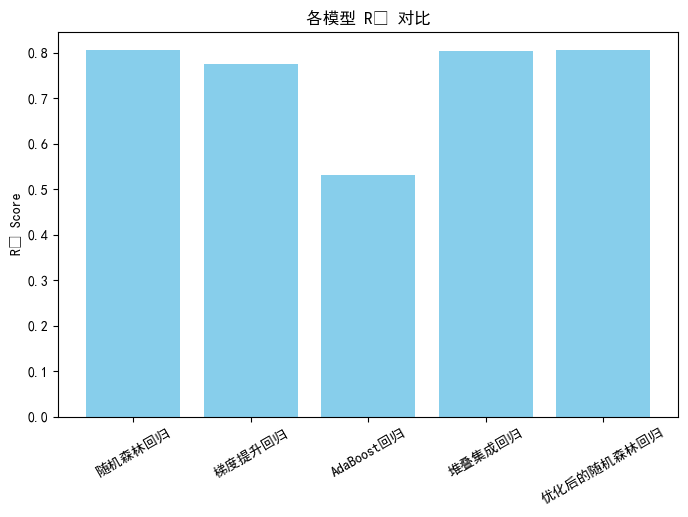

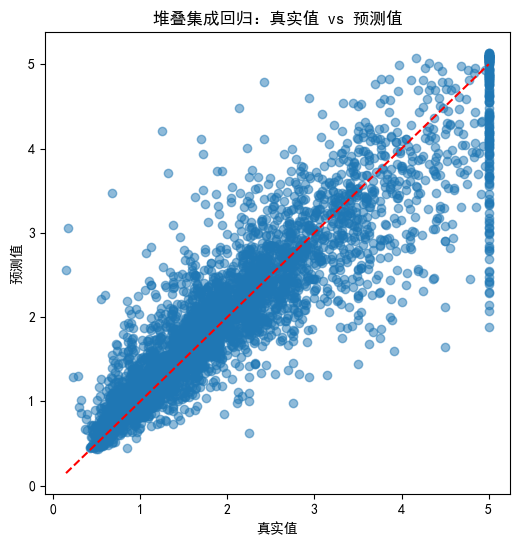

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    StackingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========== 1. 数据加载 ==========
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========== 2. 定义评估函数 ==========
results = {}

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results[model_name] = {"MSE": mse, "MAE": mae, "R2": r2}
    print(f"{model_name} 评估结果:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print("-" * 50)

# ========== 3. 训练模型 ==========
# 1. 随机森林回归
rf_reg = RandomForestRegressor(
    n_estimators=100, max_depth=None, min_samples_split=2,
    random_state=42, n_jobs=-1
)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
evaluate_model(y_test, y_pred_rf, "随机森林回归")

# 2. 梯度提升回归
gbdt_reg = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gbdt_reg.fit(X_train, y_train)
y_pred_gbdt = gbdt_reg.predict(X_test)
evaluate_model(y_test, y_pred_gbdt, "梯度提升回归")

# 3. AdaBoost回归
ada_reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=50, learning_rate=1.0, random_state=42
)
ada_reg.fit(X_train, y_train)
y_pred_ada = ada_reg.predict(X_test)
evaluate_model(y_test, y_pred_ada, "AdaBoost回归")

# 4. 堆叠集成回归
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gbdt', GradientBoostingRegressor(n_estimators=50, random_state=42)),
    ('ada', AdaBoostRegressor(n_estimators=50, random_state=42))
]
meta_model = LinearRegression()
stacking_reg = StackingRegressor(
    estimators=base_models, final_estimator=meta_model, cv=5
)
stacking_reg.fit(X_train, y_train)
y_pred_stack = stacking_reg.predict(X_test)
evaluate_model(y_test, y_pred_stack, "堆叠集成回归")

# ========== 4. 网格搜索优化随机森林 ==========
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid, cv=5, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid_search.fit(X_train, y_train)
print(f"随机森林最佳参数: {grid_search.best_params_}")
y_pred_rf_opt = grid_search.predict(X_test)
evaluate_model(y_test, y_pred_rf_opt, "优化后的随机森林回归")

# ========== 5. 可视化 ==========
# (1) 各模型 R² 对比
plt.figure(figsize=(8, 5))
model_names = list(results.keys())
r2_scores = [results[m]["R2"] for m in model_names]
plt.bar(model_names, r2_scores, color="skyblue")
plt.ylabel("R² Score")
plt.title("各模型 R² 对比")
plt.xticks(rotation=30)
plt.show()

# (2) 真实值 vs 预测值（以堆叠模型为例）
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_stack, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("真实值")
plt.ylabel("预测值")
plt.title("堆叠集成回归：真实值 vs 预测值")
plt.show()
